In [1]:
! pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 61 kB 17.6 MB/s eta 0:00:01


In [2]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
from itertools import product
import pickle
import time
import torch_optimizer as optim

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', train=True, download=True)
MNIST_test = torchvision.datasets.MNIST('./', train=False, download=True)
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [5]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from tqdm import tqdm

In [11]:
resume = False

if resume: 
    with open('sham_small_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sham = arr["acc"]
        test_loss_history_sham = arr["loss"]
        loss_in_training_sham = arr["loss_train"]
        time_learning_sham = arr["time"]
else:
    test_accuracy_history_sham, test_loss_history_sham, loss_in_training_sham, time_learning_sham = {}, {}, {}, {}

In [12]:
for learning_rate, weight_decay in product([0.1], [0]):
    
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sham:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    optimizer = optimizer = optim.Shampoo(lenet5.parameters(), lr=learning_rate, momentum=0.0, weight_decay=weight_decay, epsilon=1e-4, update_freq=1)
    batch_size = 100
    
    test_loss_history_sham[key] = list()
    test_accuracy_history_sham[key] = list()
    loss_in_training_sham[key] = list()
    time_learning_sham[key] = list()

    for epoch in tqdm(range(20)):
        order = np.random.permutation(len(X_train))
        
        start_time = time.time()
        
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        
        time_learning_sham[key].append(time.time() - start_time)
        loss_in_training_sham[key].append(float(loss(lenet5.forward(X_train), y_train)))
        print(loss_in_training_sham[key])
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_sham[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_sham[key].append(accuracy)
        print(accuracy)
    
    print(test_accuracy_history_sham[(learning_rate, weight_decay)])
    print(loss_in_training_sham[(learning_rate, weight_decay)])
    with open('sham_small_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

[0.14263495802879333]


  5%|▌         | 1/20 [01:02<19:54, 62.88s/it]

tensor(0.9690)


 10%|█         | 2/20 [01:59<17:44, 59.13s/it]

[0.14263495802879333, 0.09311401098966599]
tensor(0.9802)


 15%|█▌        | 3/20 [02:42<14:44, 52.04s/it]

[0.14263495802879333, 0.09311401098966599, 0.07410626858472824]
tensor(0.9820)
[0.14263495802879333, 0.09311401098966599, 0.07410626858472824, 0.06300033628940582]


 20%|██        | 4/20 [03:34<13:47, 51.75s/it]

tensor(0.9838)


 25%|██▌       | 5/20 [04:27<13:03, 52.27s/it]

[0.14263495802879333, 0.09311401098966599, 0.07410626858472824, 0.06300033628940582, 0.055971257388591766]
tensor(0.9856)


 30%|███       | 6/20 [05:16<11:55, 51.10s/it]

[0.14263495802879333, 0.09311401098966599, 0.07410626858472824, 0.06300033628940582, 0.055971257388591766, 0.050839707255363464]
tensor(0.9852)
[0.14263495802879333, 0.09311401098966599, 0.07410626858472824, 0.06300033628940582, 0.055971257388591766, 0.050839707255363464, 0.04665470868349075]


 35%|███▌      | 7/20 [06:06<11:00, 50.82s/it]

tensor(0.9876)


 35%|███▌      | 7/20 [06:34<12:13, 56.41s/it]


KeyboardInterrupt: 

In [6]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

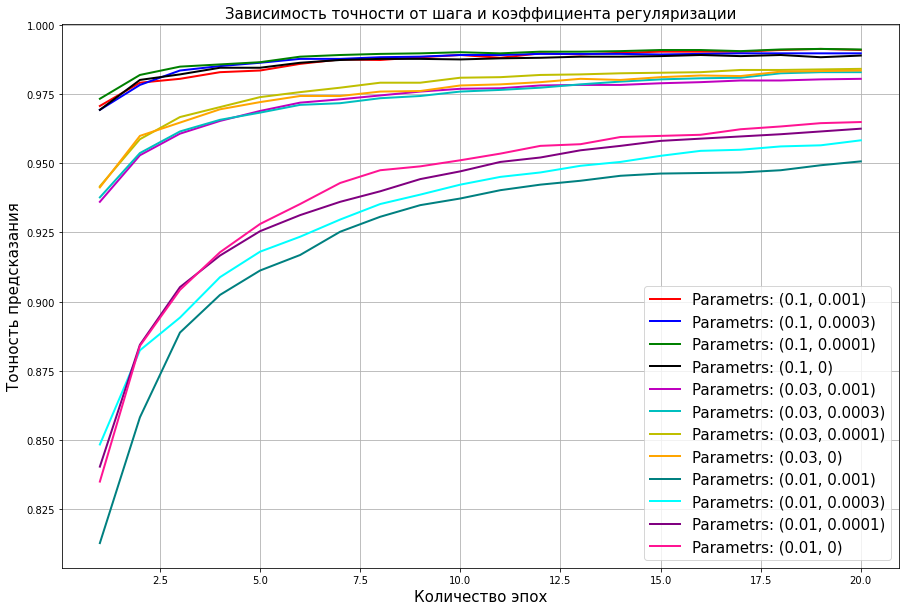

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sham.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_accrucy.png')

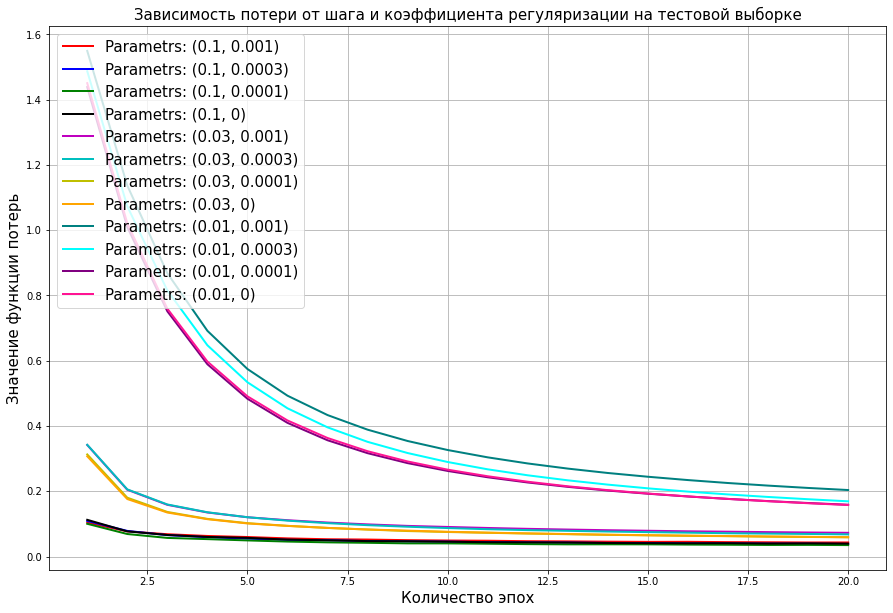

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sham.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_1_loss.png')

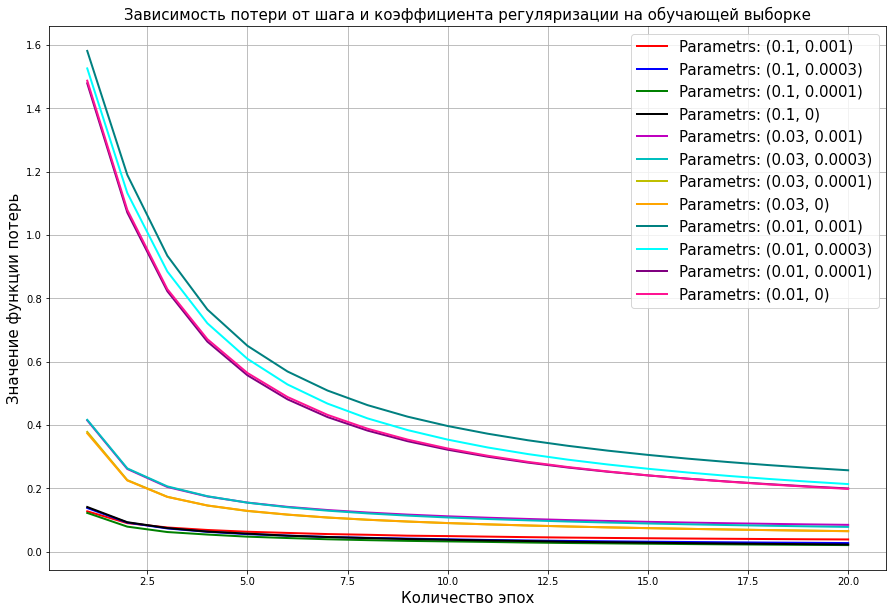

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sham.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_loss_train.png')

In [7]:
import tqdm

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
lenet5 = LeNet5()
# lenet5.cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Shampoo(lenet5.parameters(), lr=0.1, momentum=0.0, weight_decay=0.0001, epsilon=1e-4, update_freq=1)
batch_size = 100

test_loss_history_sham = list()
test_accuracy_history_sham = list()
loss_in_training_sham = list()
time_learning_sham = list()

for epoch in tqdm.tqdm(range(20)):
    order = np.random.permutation(len(X_train))
    start_time = time.time()
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        # X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        
        preds = lenet5.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()   
        optimizer.step()

    time_learning_sham.append(time.time() - start_time)
    loss_in_training_sham.append(float(loss(lenet5.forward(X_train), y_train)))

    test_preds = lenet5.forward(X_test)
    test_loss_history_sham.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_sham.append(accuracy)

with open('sham_mresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

100%|██████████| 20/20 [09:54<00:00, 29.74s/it]


In [9]:
test_accuracy_history_sham

[tensor(0.9713),
 tensor(0.9790),
 tensor(0.9834),
 tensor(0.9866),
 tensor(0.9875),
 tensor(0.9886),
 tensor(0.9886),
 tensor(0.9891),
 tensor(0.9892),
 tensor(0.9891),
 tensor(0.9888),
 tensor(0.9898),
 tensor(0.9900),
 tensor(0.9896),
 tensor(0.9898),
 tensor(0.9899),
 tensor(0.9908),
 tensor(0.9898),
 tensor(0.9904),
 tensor(0.9904)]

In [10]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [11]:
lenet5 = LeNet5()
# lenet5.cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Shampoo(lenet5.parameters(), lr=0.1, momentum=0.0, weight_decay=0.0001, epsilon=1e-4, update_freq=1)
batch_size = 100

test_loss_history_sham = list()
test_accuracy_history_sham = list()
loss_in_training_sham = list()

start_time = time.time()
accuracy = 0

while accuracy <= 0.985:
    
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        # X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        
        preds = lenet5.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()   
        optimizer.step()

    loss_in_training_sham.append(float(loss(lenet5.forward(X_train), y_train)))

    test_preds = lenet5.forward(X_test)
    test_loss_history_sham.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_sham.append(accuracy)
    
time_learning_sham = time.time() - start_time

with open('sham_mresults_985.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

In [12]:
test_accuracy_history_sham

[tensor(0.9683),
 tensor(0.9764),
 tensor(0.9809),
 tensor(0.9823),
 tensor(0.9838),
 tensor(0.9847),
 tensor(0.9857)]